# Spatial and temporal filtering of two-dimensional fields

**context** : in preparation of implementation of new indicators for CMEMS projects, a technic for filtering data

**author** : A. Albert (from a notebook by J. Lesommer )

## 0. Installations required

(ajouter proxy_servers https: https://www-cache.ujf-grenoble.fr:3128 dans ~/.condarc)

    conda install numpy
    conda install matplotlib
    conda install xarray
    pip install version_information --proxy https://www-cache.ujf-grenoble.fr:3128
    pip install seaborn --proxy https://www-cache.ujf-grenoble.fr:3128
    conda install -c conda-forge -c ioam geoviews
    conda install -c https://conda.binstar.org/ioos cartopy
    
Refresh oocgcm package :

    cd ~/oocgcm
    git pull
    python setup.py install --home=~
    


## 1. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.1
xarray 0.9.1
Fri Feb 10 11:21:37 2017 CET

In [2]:
import sys

sys.path.insert(0,"/home/albert/lib/python")

print(sys.path)

['/home/albert/lib/python', '', '/home/albert/anaconda2/lib/python2.7/site-packages/oocgcm-0.1.0-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/numpy-1.11.1-py2.7-linux-x86_64.egg', '/home/albert/anaconda2/lib/python27.zip', '/home/albert/anaconda2/lib/python2.7', '/home/albert/anaconda2/lib/python2.7/plat-linux2', '/home/albert/anaconda2/lib/python2.7/lib-tk', '/home/albert/anaconda2/lib/python2.7/lib-old', '/home/albert/anaconda2/lib/python2.7/lib-dynload', '/home/albert/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.1-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/colormap-0.9.8-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages/setuptools-23.0.0-py2.7.egg', '/home/albert/anaconda2/lib/python2.7/site-packages', '/home/albert/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/albert/.ipython']


In [3]:
## standart libraries
import os,sys,user,glob
import numpy as np

## third party imports
import xarray as xr

#import pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline 
# doesnt work if put in previous block...

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf


## 2. Using test dataset
The test dataset can be retrieved from https://www.dropbox.com/s/2wq18xivtrjyy52/ORCA025_SSH_SWPAC.nc?dl=0. Here, I have put the dataset in $HOME/data/ORCA025

In [4]:
sigdir = user.home + "/Data/ORCA025/"
test_file = 'ORCA025_SSH_SWPAC.nc'
sigdir + test_file


'/home/albert/Data/ORCA025/ORCA025_SSH_SWPAC.nc'

<xarray.DataArray 'sossheig' (time_counter: 300, y: 184, x: 224)>
dask.array<xarray-..., shape=(300, 184, 224), dtype=float64, chunksize=(50, 184, 224)>
Coordinates:
    nav_lon       (y, x) float64 134.5 134.8 135.0 135.2 135.5 135.8 136.0 ...
  * time_counter  (time_counter) float64 73.04 nan nan nan nan nan nan nan ...
    nav_lat       (y, x) float64 -45.18 -45.18 -45.18 -45.18 -45.18 -45.18 ...
Dimensions without coordinates: y, x


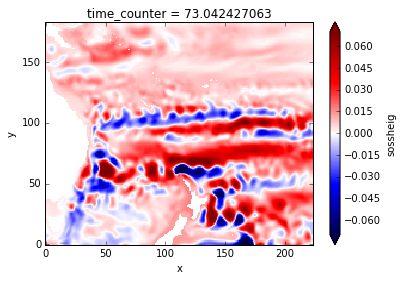

In [5]:
signal_xyt = xr.open_dataset(sigdir + test_file, decode_times=False,engine='scipy')['sossheig'].chunk(chunks={'time_counter': 50})
print signal_xyt
signal_xyt.isel(time_counter=0).plot(vmin=-0.07, vmax=0.07, cmap='seismic')

In [6]:
win1D = signal_xyt.win


## 3. Temporal filtering :

### Boxcar window

A boxcar window object that will be applied along the time dimension is simply be defined by setting its different properties :

In [7]:
win1D.set(window_name='boxcar', n=[5], dims=['time_counter'])
print win1D._depth.values()
print win1D

[5]
Window [name->boxcar,dims->['time_counter'],order->{'time_counter': 5}]


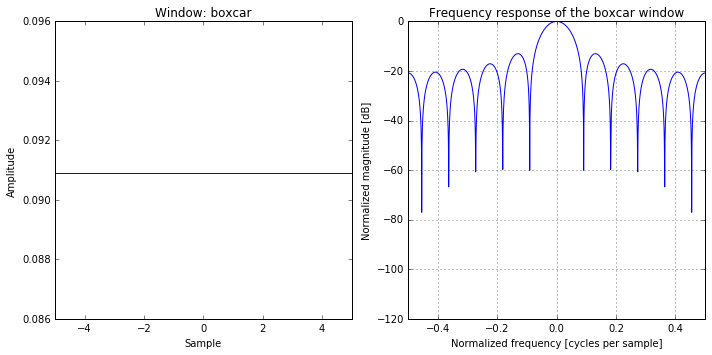

In [8]:
win1D.plot()

In [9]:
signal_LF_box=win1D.apply(compute=True)

[########################################] | 100% Completed |  0.5s


/home/albert/anaconda2/lib/python2.7/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in divide
  if not reflexive


### Lanczos window

Setting now different properties to use a Lanczos window :

/home/albert/lib/python/oocgcm/filtering/linearfilters.py:58: RuntimeWarning: invalid value encountered in divide
  np.sin(np.pi * k / (n / 2.)) / (np.pi * k / (n / 2.)))


Window [name->lanczos,dims->['time_counter'],order->{'time_counter': 5}]


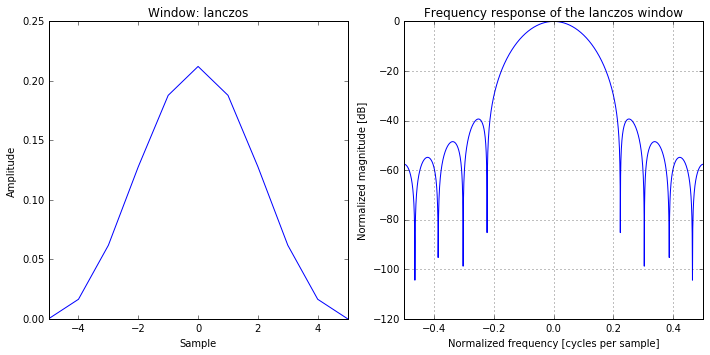

In [10]:
win1D.set(window_name='lanczos', n=[5], dims=['time_counter'], fc=0.1)
print win1D
win1D.plot()

In [11]:
signal_LF_lcz=win1D.apply(compute=True)

[########################################] | 100% Completed |  0.4s


### Results

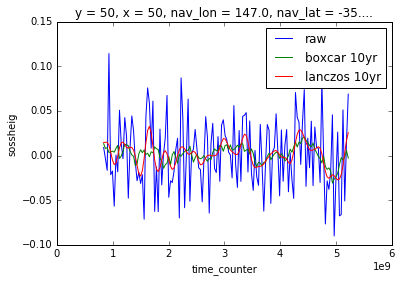

In [12]:
signal_xyt.isel(x=50, y=50).plot()
signal_LF_box.isel(x=50,y=50).plot(color='g')
signal_LF_lcz.isel(x=50, y=50).plot(color='r')
plt.legend(['raw','boxcar 10yr','lanczos 10yr'])

## 4. Spatial filtering


In [13]:
signal_xyt = xr.open_dataset(sigdir + test_file, decode_times=False,engine='scipy')['sossheig'].chunk(chunks={'x': 40, 'y':40})
win_box2D = signal_xyt.win
win_box2D.set(window_name='lanczos', n=[24, 24], dims=['x', 'y'], fc=0.0416)
print signal_xyt
print win_box2D

<xarray.DataArray 'sossheig' (time_counter: 300, y: 184, x: 224)>
dask.array<xarray-..., shape=(300, 184, 224), dtype=float64, chunksize=(300, 40, 40)>
Coordinates:
    nav_lon       (y, x) float64 134.5 134.8 135.0 135.2 135.5 135.8 136.0 ...
  * time_counter  (time_counter) float64 73.04 nan nan nan nan nan nan nan ...
    nav_lat       (y, x) float64 -45.18 -45.18 -45.18 -45.18 -45.18 -45.18 ...
Dimensions without coordinates: y, x
Window [name->lanczos,dims->['x', 'y'],order->{'y': 24, 'x': 24}]


{1: 24, 2: 24}
(49, 49)


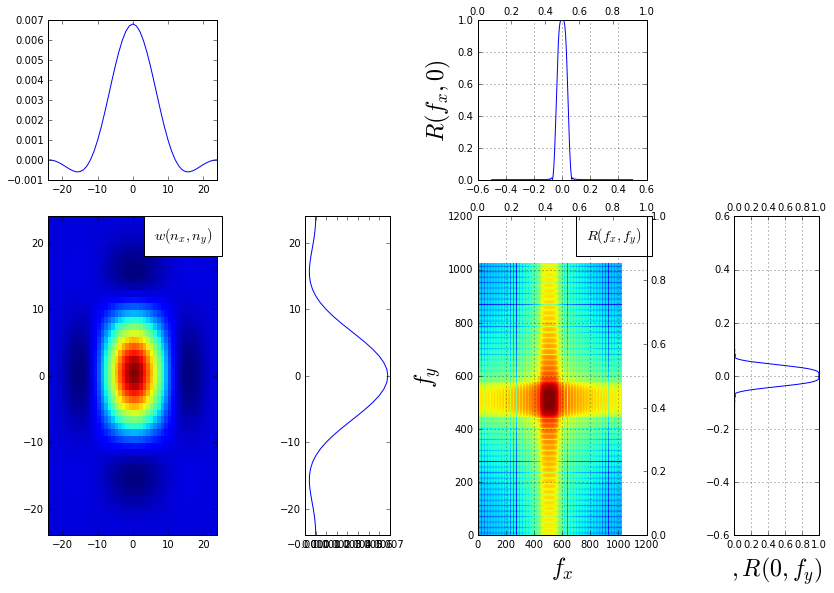

In [14]:
win_box2D.plot()

### original dataset

In [15]:
bw = win_box2D.boundary_weights(drop_dims=[])

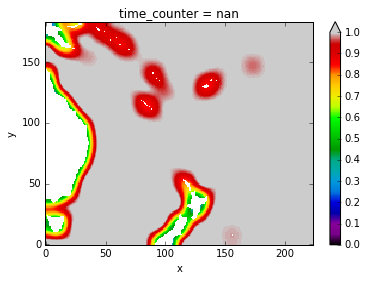

In [16]:
bw.isel(time_counter=1).plot(vmin=0, vmax=1, cmap='spectral')


In [17]:
signal_LS = win_box2D.apply(weights=bw)

[########################################] | 100% Completed | 30.1s


/home/albert/anaconda2/lib/python2.7/site-packages/dask/array/reductions.py:278: RuntimeWarning: invalid value encountered in true_divide
  u = total/n
/home/albert/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


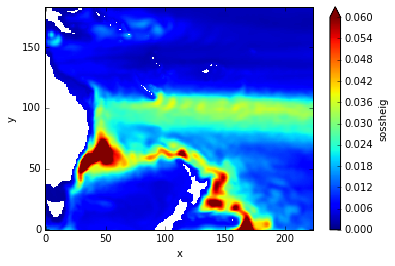

In [18]:
# Original dataset
signal_xyt.std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

### large scales (>6°)

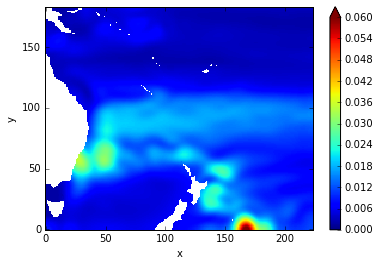

In [19]:
# Large-scale (>6°) dataset
signal_LS.std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

### small scales (<6°)